In [1]:
# !pip install -e .

In [2]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import jax.numpy as jnp
from random import randint
import jax
from jax.scipy.spatial.transform import Rotation as R
from diff_gaussian_rasterization import _C
import jax.numpy as jnp
import jax
import functools
from jax import core, dtypes
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def getProjectionMatrix(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

from typing import NamedTuple
class Intrinsics(NamedTuple):
    height: int
    width: int
    fx: float
    fy: float
    cx: float
    cy: float
    near: float
    far: float

In [4]:
def torch_to_jax(torch_array):
    return jnp.array(torch_array.detach().cpu().numpy())

default_seed = 1222
gt_seed = 1201223

In [5]:
from jax_renderer import _build_rasterize_gaussians_fwd_primitive

rasterize_gaussians_fwd


N= 100
0.7499999908297853 1.3333333054880079
0.0 0.7826992273330688 0.023123091086745262
JAX RENDERED=[423]
0.0


/var/tmp/ipykernel_56542/2006746011.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
/var/tmp/ipykernel_56542/2006746011.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  opacity = torch.sigmoid(torch.tensor(torch.ones((N,1)), requires_grad=True, device=device))
/var/tmp/ipykernel_56542/2006746011.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, dev

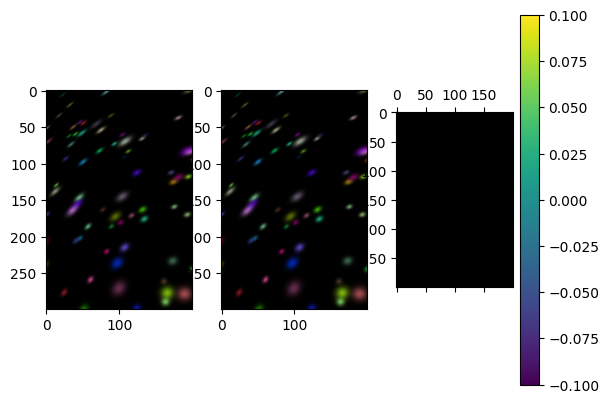

: 

In [9]:
intrinsics = Intrinsics(
    height=300,
    width=200,
    fx=300.0, fy=300.0,
    cx=100.0, cy=100.0,
    near=0.01, far=2.5
)

torch.manual_seed(gt_seed)
import random
random.seed(gt_seed)
np.random.seed(gt_seed)

N = 100
print("N=",N)

means3D = torch.tensor(torch.rand((N,3))-0.5 + torch.tensor([0.0, 0.0, 1.0]), requires_grad=True, device=device)
# means3D = torch.tensor([[0.4, 0.0, 1.0]], requires_grad=True, device=device)
means2D = torch.zeros_like(means3D, dtype=means3D.dtype, requires_grad=True, device="cuda") + 0
opacity = torch.sigmoid(torch.tensor(torch.ones((N,1)), requires_grad=True, device=device))
colors_precomp = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device).detach()
shs = torch.tensor(torch.rand((N,3)), requires_grad=True, device=device).detach()
scales = torch.exp(torch.tensor(-10.0 * torch.ones((N,3)), requires_grad=True, device=device))
rotations = torch.tensor(-10.0 * torch.ones((N,4)), requires_grad=True, device=device)
cov3D_precomp = torch.tensor(0.01 * torch.ones((N,3)), requires_grad=True, device=device)

fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2.0
fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2.0
tan_fovx = math.tan(fovX)
tan_fovy = math.tan(fovY)
print(tan_fovx, tan_fovy)

camera_pose_jax = jnp.eye(4)
proj_matrix = getProjectionMatrix(0.01, 100.0, fovX, fovY).transpose(0,1).cuda()
view_matrix = torch.transpose(torch.tensor(np.array(jnp.linalg.inv(camera_pose_jax))),0,1).cuda()
projmatrix = view_matrix @ proj_matrix

raster_settings = GaussianRasterizationSettings(
    image_height=int(intrinsics.height),
    image_width=int(intrinsics.width),
    tanfovx=tan_fovx,
    tanfovy=tan_fovy,
    bg=torch.tensor([0.0, 0.0, 0.0]).cuda(),
    scale_modifier=1.0,
    viewmatrix=view_matrix,
    projmatrix=projmatrix,
    sh_degree=0,
    campos=torch.zeros(3).cuda(),
    prefiltered=False,
    debug=None
)
# rasterizer = GaussianRasterizerJax(raster_settings=raster_settings)
rasterizer = GaussianRasterizer(raster_settings=raster_settings)

color,radii = rasterizer(
    means3D = means3D,
    means2D = means2D,
    colors_precomp = colors_precomp,
    opacities = opacity,
    scales = scales,
    rotations = rotations,
    # cov3D_precomp=cov3D_precomp
)
# print(colors_precomp_gt)
print(color.min().item(), color.max().item(), color.mean().item())
color_gt = color.detach()
colors_gt = jnp.array(torch.permute(color_gt, (1,2,0)).cpu().detach().numpy()[...,:3])


# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.imshow(colors_gt)
# ax2.imshow(jnp.transpose(color, (1,2,0))[...,:3])

primitive = _build_rasterize_gaussians_fwd_primitive()

bg = jnp.zeros(3)
means3D = torch_to_jax(means3D)
colors_precomp = torch_to_jax(colors_precomp)
opacities = torch_to_jax(opacity)
scales = torch_to_jax(scales)
rotations = torch_to_jax(rotations)
cov3D_precomp = torch_to_jax(cov3D_precomp)
shs = torch_to_jax(shs)
viewmatrix = torch_to_jax(view_matrix)
projmatrix = torch_to_jax(projmatrix)
image_height = int(intrinsics.height)
image_width = int(intrinsics.width)
sh_degree = 0
campos = jnp.zeros(3)

outs = primitive.bind(
            bg,
            means3D,
            colors_precomp,
            opacities,
            scales,
            rotations,
            cov3D_precomp,
            viewmatrix,
            projmatrix,
            shs,
            campos,
            tanfovx=tan_fovx, tanfovy=tan_fovy, image_height=image_height, image_width=image_width,  sh_degree=sh_degree
)
rendered = outs[0]
print(f"JAX RENDERED={rendered}")
color = outs[1]
# rendered, out_color, radii, geomBuffer, binningBuffer, imgBuffer

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
color = jnp.transpose(color, (1,2,0))[...,:3]
ax1.imshow(colors_gt)
ax2.imshow(color)
x = ax3.matshow(jnp.abs(color -colors_gt))
print(jnp.abs(color -colors_gt).sum())
fig.colorbar(x, ax=ax3)